In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-dev20191002


We will be addressing this problem as a time series sequence model where there is multivariate time series(s) - data usage by various users -  as training data for our model.We will then perform predictive analysis using deep learning techniques such as Recurrent Neural Networks with stacked LSTM units to predict the next cycle of values that the time series is expected to show in the future; thus, allowing us to predict how the limited bandwidth should be distributed among various cell towers.  


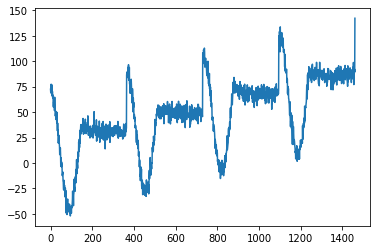

In [25]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 4 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 60
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plt.plot(series)

-> The plot series function and the various other functions given in the intial cell of our Notebook help in creating a time series which serves as our dataset with Realistic Trend, Seasonality, Seasonal Pattern and also Noise. 


The 'windowed_dataset' function is used create a window which interates over our training data and this function is crucial in the data preprocessing technique for our Neural Network.


In [26]:
# def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
#   series = tf.expand_dims(series, axis=-1)
#   dataset = tf.data.Dataset.from_tensor_slices(series)
#   dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
#   dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
#   dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
#   dataset = dataset.batch(batch_size).prefetch(1)
#   return dataset

def windowed_dataset(series1, window_size, batch_size, shuffle_buffer):
    series1 = tf.expand_dims(series1, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series1)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


We have then designed a Deep Convolutional Nerual Network (DCNN) with 1 Convolution layer, two stacked bidirectional LSTMs as our Recurrant Neural Network and a dense layer to wrap it all up. We would also like to mention that we have went over multiple versions of our Neural Network architecture to fine tune it to best fit the data. 


In [27]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])


lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 7s 835ms/step - loss: 69.7960 - mae: 70.3733
Epoch 2/100
8/8 [==============================] - 1s 187ms/step - loss: 69.4795 - mae: 69.9539
Epoch 3/100
8/8 [==============================] - 1s 139ms/step - loss: 68.9750 - mae: 69.2763
Epoch 4/100
8/8 [==============================] - 1s 153ms/step - loss: 68.0263 - mae: 68.4245
Epoch 5/100
8/8 [==============================] - 1s 114ms/step - loss: 66.7681 - mae: 67.4376
Epoch 6/100
8/8 [==============================] - 1s 147ms/step - loss: 65.7940 - mae: 66.2883
Epoch 7/100
8/8 [==============================] - 1s 152ms/step - loss: 64.5833 - mae: 64.9913
Epoch 8/100
8/8 [==============================] - 1s 166ms/step - loss: 63.1226 - mae: 63.5137
Epoch 9/100
8/8 [==============================] - 1s 124ms/step - loss: 61.2747 - mae: 61.8423
Epoch 10/100
8/8 [==============================] - 1s 160ms/step - loss: 59.4858 - mae: 59.9124
Epoch 11/100
8/8 [=====================

We have also performed HyperParameter tuning on our learning rate by plotting a semilogx graph to find out the best Learning Rate to address our model.


[1e-08, 0.0001, 0, 30]

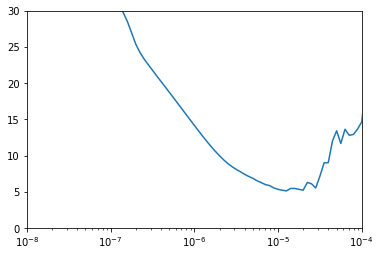

In [28]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

We now retrain our model with the most efficient 'Learning Rate'
We used Huber Loss to predict the loss in every iteration. 

In [29]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
31/31 [==============================] - 4s 138ms/step - loss: 23.1450 - mae: 23.9299
Epoch 2/500
31/31 [==============================] - 1s 46ms/step - loss: 9.9743 - mae: 10.4559
Epoch 3/500
31/31 [==============================] - 1s 47ms/step - loss: 8.4825 - mae: 9.0088
Epoch 4/500
31/31 [==============================] - 1s 45ms/step - loss: 7.7149 - mae: 8.1799
Epoch 5/500
31/31 [==============================] - 1s 46ms/step - loss: 7.2267 - mae: 7.6965
Epoch 6/500
31/31 [==============================] - 1s 47ms/step - loss: 7.0637 - mae: 7.5638
Epoch 7/500
31/31 [==============================] - 2s 56ms/step - loss: 6.5058 - mae: 7.0036
Epoch 8/500
31/31 [==============================] - 1s 47ms/step - loss: 6.2536 - mae: 6.7508
Epoch 9/500
31/31 [==============================] - 1s 43ms/step - loss: 6.0732 - mae: 6.5654
Epoch 10/500
31/31 [==============================] - 1s 46ms/step - loss: 5.9204 - mae: 6.3925
Epoch 11/500
31/31 [=========================

31/31 [==============================] - 1s 43ms/step - loss: 4.2163 - mae: 4.6902
Epoch 171/500
31/31 [==============================] - 1s 43ms/step - loss: 4.3446 - mae: 4.8115
Epoch 172/500
31/31 [==============================] - 1s 48ms/step - loss: 4.1817 - mae: 4.6641
Epoch 173/500
31/31 [==============================] - 2s 50ms/step - loss: 4.1819 - mae: 4.6532
Epoch 174/500
31/31 [==============================] - 1s 43ms/step - loss: 4.2426 - mae: 4.7182
Epoch 175/500
31/31 [==============================] - 1s 44ms/step - loss: 4.1849 - mae: 4.6606
Epoch 176/500
31/31 [==============================] - 1s 42ms/step - loss: 4.1669 - mae: 4.6351
Epoch 177/500
31/31 [==============================] - 1s 41ms/step - loss: 4.5302 - mae: 5.0033
Epoch 178/500
31/31 [==============================] - 1s 43ms/step - loss: 4.2928 - mae: 4.7652
Epoch 179/500
31/31 [==============================] - 1s 44ms/step - loss: 4.1923 - mae: 4.6588
Epoch 180/500
31/31 [=======================

31/31 [==============================] - 2s 49ms/step - loss: 4.1028 - mae: 4.5686
Epoch 339/500
31/31 [==============================] - 1s 43ms/step - loss: 4.0525 - mae: 4.5222
Epoch 340/500
31/31 [==============================] - 1s 44ms/step - loss: 4.1351 - mae: 4.6155
Epoch 341/500
31/31 [==============================] - 1s 46ms/step - loss: 4.0743 - mae: 4.5494
Epoch 342/500
31/31 [==============================] - 1s 46ms/step - loss: 4.0155 - mae: 4.4950
Epoch 343/500
31/31 [==============================] - 1s 48ms/step - loss: 4.1002 - mae: 4.5739
Epoch 344/500
31/31 [==============================] - 1s 42ms/step - loss: 4.0460 - mae: 4.5124
Epoch 345/500
31/31 [==============================] - 1s 46ms/step - loss: 4.0133 - mae: 4.4871
Epoch 346/500
31/31 [==============================] - 1s 48ms/step - loss: 4.0202 - mae: 4.4869
Epoch 347/500
31/31 [==============================] - 1s 43ms/step - loss: 4.0830 - mae: 4.5583
Epoch 348/500
31/31 [=======================

In the end we have plotted, the predicted values (in orange) of our validation dataset (in blue) - to see how good our model is predicting the data that our model hasn't seen before. 
The 'model_forecast' function is used to predicted the bandwidth allocation for one cycle. 

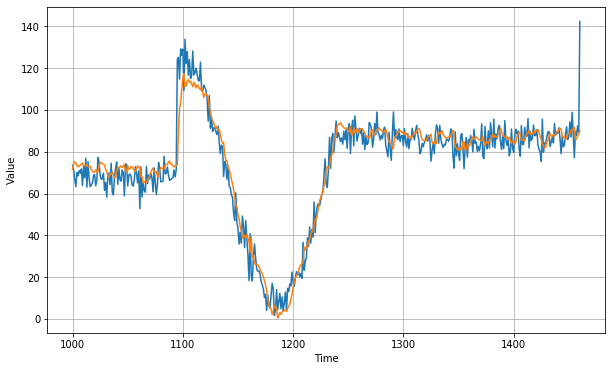

In [30]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)


In [31]:
model.save("x_train_tuning_Rishie_3.h5")
print("Saved model to disk")

Saved model to disk


In [38]:
# We have reahced a good accuracy at estimating the Bandwidth demand with a 'MAE' (Mean Absolute Error) of 5.45 (Usually ~30)
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.456056

In [33]:
rnn_forecast
# The forecasted values 

array([ 71.748116  ,  74.14854   ,  75.179695  ,  74.55066   ,
        73.22695   ,  72.83354   ,  73.26251   ,  73.594246  ,
        74.12769   ,  74.58177   ,  73.3255    ,  73.319046  ,
        73.43358   ,  74.01576   ,  72.74144   ,  73.000496  ,
        72.94858   ,  71.360344  ,  70.74077   ,  70.15795   ,
        70.397964  ,  71.294876  ,  70.42559   ,  70.285835  ,
        72.938156  ,  75.01222   ,  74.59693   ,  74.306526  ,
        73.939575  ,  73.71341   ,  71.64847   ,  70.50213   ,
        68.61426   ,  67.68473   ,  69.53068   ,  69.24913   ,
        70.378265  ,  69.11458   ,  67.626495  ,  67.979324  ,
        70.308624  ,  72.85912   ,  72.12038   ,  72.814384  ,
        73.26759   ,  72.47508   ,  72.97643   ,  73.88871   ,
        70.65874   ,  70.48412   ,  73.2919    ,  71.61658   ,
        71.775986  ,  72.78499   ,  72.88343   ,  71.96651   ,
        70.86123   ,  70.5114    ,  72.15796   ,  73.223816  ,
        72.32647   ,  72.691574  ,  68.03941   ,  68.04

We can also observe from the graph below that our loss tends to decrease with the number of epochs which assures that our model just keeps getting better !!!


<Figure size 432x288 with 0 Axes>

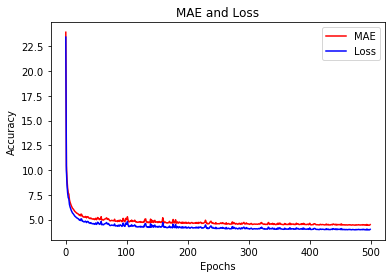

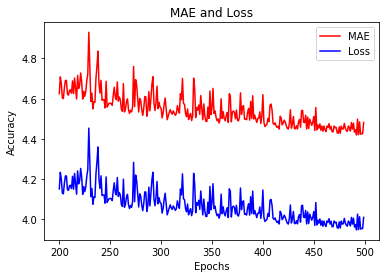

<Figure size 432x288 with 0 Axes>

In [35]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()